In [17]:
import pandas as pd
from enum import Enum

In [18]:
EVENTS_FILE = "data/hyrox.csv"
HOUSTON_EVENT_ID = "LR3MS4JIA19"
NATIONALITY_GER = "GER"

In [19]:
class AgeGroup(Enum):
    AG_16_24 = '16-24'
    AG_25_29 = '25-29'
    AG_30_34 = '30-34'
    AG_35_39 = '35-39'
    AG_40_44 = '40-44'
    AG_45_49 = '45-49'
    AG_50_54 = '50-54'
    AG_55_59 = '55-59'
    AG_60_64 = '60-64'
    AG_65_69 = '65-69'
    AG_70_74 = '70-74'
    AG_75_79 = '75-79'
    AG_80_84 = '80-84'

X_COLS_RUN_AGG = [
    'run_time_sec', 
    'SKI_sec', 
    'SPS_sec',
    'SPL_sec', 
    'BBJ_sec',  
    'ROW_sec',
    'FRC_sec',
    'LUN_sec', 
    'WBL_sec',
]

X_COLS_RUN_SPLIT = [
    'run_1_sec',
    'run_2_sec', 
    'run_3_sec', 
    'run_4_sec', 
    'run_5_sec', 
    'run_6_sec', 
    'run_7_sec', 
    'run_8_sec',
    'SKI_sec', 
    'SPS_sec',
    'SPL_sec', 
    'BBJ_sec',  
    'ROW_sec',
    'FRC_sec',
    'LUN_sec', 
    'WBL_sec',
]


In [20]:
def rename_cols(df: pd.DataFrame):
    workout_map = {
        "work_1": "SKI",
        "work_2": "SPS",
        "work_3": "SPL",
        "work_4": "BBJ",
        "work_5": "ROW",
        "work_6": "FRC",
        "work_7": "LUN",
        "work_8": "WBL",
    }
    return df.rename(columns=workout_map)


def convert_duriation_columns_to_seconds(df):
    duration_cols = [
        'total_time', 
        'work_time', 
        'roxzone_time', 
        'run_time',
        'run_1', 
        'SKI', 
        'roxzone_1', 
        'run_2', 
        'SPS', 
        'roxzone_2', 
        'run_3', 
        'SPL', 
        'roxzone_3', 
        'run_4', 
        'BBJ', 
        'roxzone_4', 
        'run_5', 
        'ROW', 
        'roxzone_5', 
        'run_6', 
        'FRC', 
        'roxzone_6', 
        'run_7', 
        'LUN', 
        'roxzone_7', 
        'run_8', 
        'WBL', 
        'roxzone_8'
    ]
    
    for col in duration_cols:
        # 1) parse strings as timedeltas; 2) extract total seconds; 3) cast to int
        df[col + '_sec'] = (
            pd.to_timedelta(df[col], errors='coerce')
              .dt.total_seconds()
              .astype('Int64')
        )
    return df

def rank_over(df: pd.DataFrame, partition_cols: list[str], column: str, rank_col: str = 'rank'):
    df[rank_col] = (
        df
        .groupby(partition_cols)[column]
        .rank(method='dense', ascending=True)
        .astype(int)
    )
    return df


def remove_invalid_rows(df: pd.DataFrame):
    no_age_group = df.age_group.isna()
    zero_total_time = df.total_time_sec == 0
    excl_age_group = df.age_group == AgeGroup.AG_80_84.value
    keep = ~(no_age_group | zero_total_time | excl_age_group)
    return df[keep]

In [21]:
hyrox = pd.read_csv(EVENTS_FILE)

hyrox = rename_cols(hyrox)

hyrox = convert_duriation_columns_to_seconds(hyrox)

hyrox = remove_invalid_rows(hyrox)

hyrox = rank_over(
    hyrox, 
    partition_cols=['event_id', 'age_group'],
    column='total_time_sec',
    rank_col='event_ag_rank'
)

hyrox = rank_over(
    hyrox, 
    partition_cols=['age_group'],
    column='total_time_sec',
    rank_col='overall_ag_rank'
)


# Percentile ranks
hyrox['age_group_max_rank'] = hyrox.groupby(['age_group'])['overall_ag_rank'].transform('max')
hyrox['age_group_pct'] = (hyrox['overall_ag_rank'] - 1) / (hyrox['age_group_max_rank'] - 1)

hyrox['age_group_pct_group'] = pd.cut(
    hyrox['age_group_pct'],
    bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
    labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    include_lowest=True
).astype(int)

In [22]:
hyrox.head()

,event_id,event_name,gender,nationality,age_group,division,total_time,work_time,roxzone_time,run_time,...,LUN_sec,roxzone_7_sec,run_8_sec,WBL_sec,roxzone_8_sec,event_ag_rank,overall_ag_rank,age_group_max_rank,age_group_pct,age_group_pct_group
0,JGDMS4JI80F,S8 2024 Singapore National Stadium,male,NED,35-39,open,1:05:53,0:28:04,0:05:11,0:32:38,...,209,52,267,259,0,1,380,4341,0.087327,1
1,JGDMS4JI80F,S8 2024 Singapore National Stadium,male,HKG,30-34,open,1:06:32,0:29:16,0:04:31,0:32:45,...,212,46,267,316,0,2,464,4485,0.103256,2
2,JGDMS4JI80F,S8 2024 Singapore National Stadium,male,FRA,30-34,open,1:08:34,0:29:11,0:05:51,0:33:32,...,209,60,276,276,0,3,586,4485,0.130464,2
3,JGDMS4JI80F,S8 2024 Singapore National Stadium,male,GBR,30-34,open,1:10:02,0:26:32,0:06:36,0:36:54,...,195,56,302,219,0,4,674,4485,0.150089,2
4,JGDMS4JI80F,S8 2024 Singapore National Stadium,male,ESP,35-39,open,1:10:36,0:29:52,0:04:58,0:35:46,...,237,56,291,316,0,2,661,4341,0.152074,2


# Data exploration

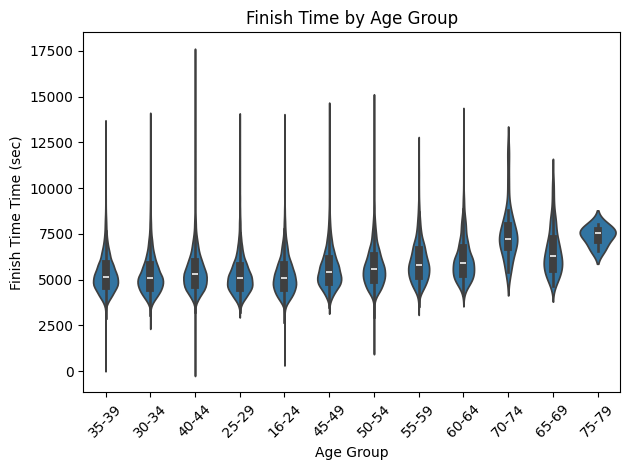

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Finish time by age group
sns.violinplot(data=hyrox, x='age_group', y='total_time_sec', inner='box')
plt.title("Finish Time by Age Group")
plt.ylabel("Finish Time Time (sec)")
plt.xlabel("Age Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


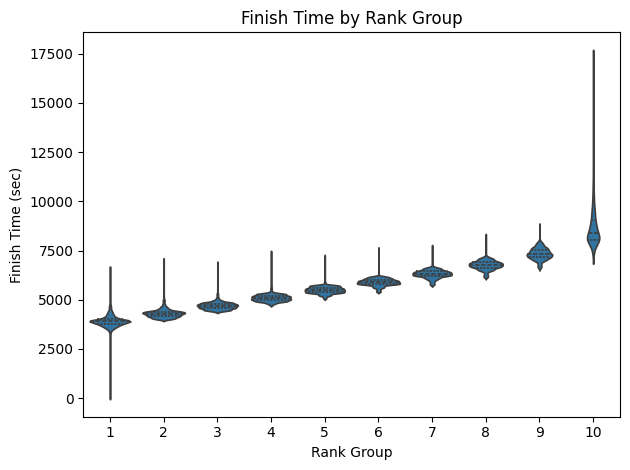

In [24]:
sns.violinplot(data=hyrox, x='age_group_pct_group', y='total_time_sec', inner='quartile')
plt.title("Finish Time by Rank Group")
plt.ylabel("Finish Time (sec)")
plt.xlabel("Rank Group")
plt.tight_layout()
plt.show()


In [25]:
# Correlation matrix

hyrox[X_COLS_RUN_AGG].corr()

,run_time_sec,SKI_sec,SPS_sec,SPL_sec,BBJ_sec,ROW_sec,FRC_sec,LUN_sec,WBL_sec
run_time_sec,1.000000,0.537026,0.402869,0.531300,0.598841,0.610196,0.488596,0.590378,0.511416
SKI_sec,0.537026,1.000000,0.447898,0.587764,0.486631,0.649865,0.485670,0.494257,0.541533
SPS_sec,0.402869,0.447898,1.000000,0.564487,0.367126,0.426328,0.437498,0.408602,0.422658
SPL_sec,0.531300,0.587764,0.564487,1.000000,0.513314,0.593688,0.559157,0.525059,0.558624
BBJ_sec,0.598841,0.486631,0.367126,0.513314,1.000000,0.549453,0.442942,0.686626,0.629808
ROW_sec,0.610196,0.649865,0.426328,0.593688,0.549453,1.000000,0.524707,0.552033,0.569079
FRC_sec,0.488596,0.485670,0.437498,0.559157,0.442942,0.524707,1.000000,0.491477,0.501878
LUN_sec,0.590378,0.494257,0.408602,0.525059,0.686626,0.552033,0.491477,1.000000,0.640339
WBL_sec,0.511416,0.541533,0.422658,0.558624,0.629808,0.569079,0.501878,0.640339,1.000000


# Impact analysis

In [27]:
import statsmodels.api as sm

X = hyrox[X_COLS_RUN_AGG]
y = hyrox['age_group_pct_group']

X = sm.add_constant(X.astype(float))

model = sm.OLS(y, X).fit()

print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     age_group_pct_group   R-squared:                       0.894
Model:                             OLS   Adj. R-squared:                  0.894
Method:                  Least Squares   F-statistic:                 9.525e+04
Date:                 Thu, 26 Jun 2025   Prob (F-statistic):               0.00
Time:                         13:11:12   Log-Likelihood:            -1.1350e+05
No. Observations:               101730   AIC:                         2.270e+05
Df Residuals:                   101720   BIC:                         2.271e+05
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -7.1359      0.032   -

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from mord import LogisticIT
import numpy as np

clf = make_pipeline(
    StandardScaler(),
    LogisticIT(alpha=1.0)
)
clf.fit(hyrox[X_COLS_RUN_AGG].astype(float), hyrox['age_group_pct_group'].astype(int))


# Feature importance: Coefficient and Odds Ratio

beta = clf.named_steps['logisticit'].coef_
odds_ratio = np.exp(beta)

df_imp = pd.DataFrame({
    'feature': hyrox[X_COLS_RUN_AGG].columns,
    'coef': beta,
    'odds_ratio': odds_ratio
}).sort_values('coef', ascending=False)

print(df_imp)

        feature      coef  odds_ratio
0  run_time_sec  5.073399  159.716303
4       BBJ_sec  1.196560    3.308716
8       WBL_sec  1.196104    3.307207
3       SPL_sec  1.035849    2.817498
7       LUN_sec  0.869359    2.385382
2       SPS_sec  0.490187    1.632621
5       ROW_sec  0.484346    1.623113
6       FRC_sec  0.470597    1.600950
1       SKI_sec  0.178323    1.195212


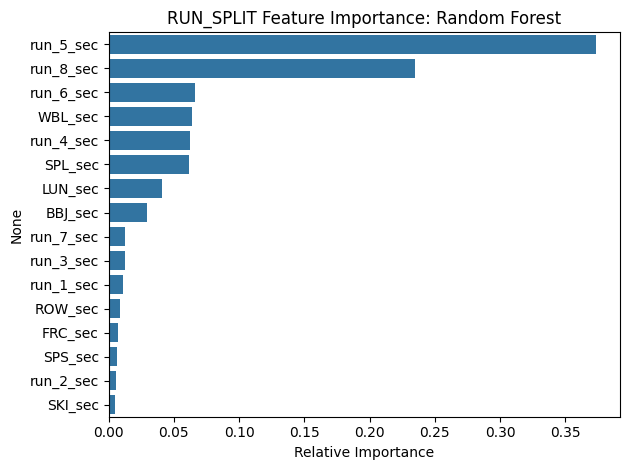

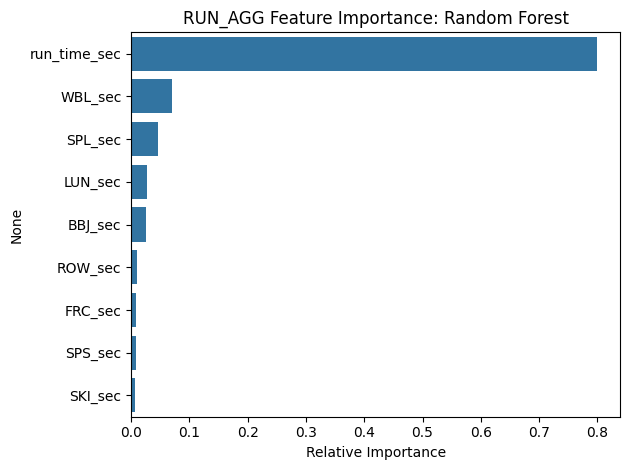

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


def get_random_forest_regressor() -> RandomForestRegressor:
    return RandomForestRegressor(n_estimators=100, random_state=42)


def plot_feature_importance(rf: RandomForestRegressor, X: pd.DataFrame, description: str):
    importances = rf.feature_importances_
    feature_names = X.columns
    
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    sns.barplot(x=fi.values, y=fi.index)
    plt.title(f"{description} Feature Importance: Random Forest")
    plt.xlabel("Relative Importance")
    plt.tight_layout()
    plt.show()


def fit_random_forest(X: pd.DataFrame, y: pd.Series) -> RandomForestRegressor:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = get_random_forest_regressor()
    rf.fit(X_train, y_train)
    return rf, X_train, X_test, y_train, y_test
    

y = hyrox['age_group_pct_group']

rf_run_split, X_train_split, X_test_split, y_train_split, y_test_split = fit_random_forest(hyrox[X_COLS_RUN_SPLIT], y)
plot_feature_importance(rf_run_split, hyrox[X_COLS_RUN_SPLIT], "RUN_SPLIT")

rf_run_agg, X_train_agg, X_test_agg, y_train_agg, y_test_agg = fit_random_forest(hyrox[X_COLS_RUN_AGG], y)
plot_feature_importance(rf_run_agg, hyrox[X_COLS_RUN_AGG], "RUN_AGG")

100%|===================| 1635/1637 [07:40<00:00]        

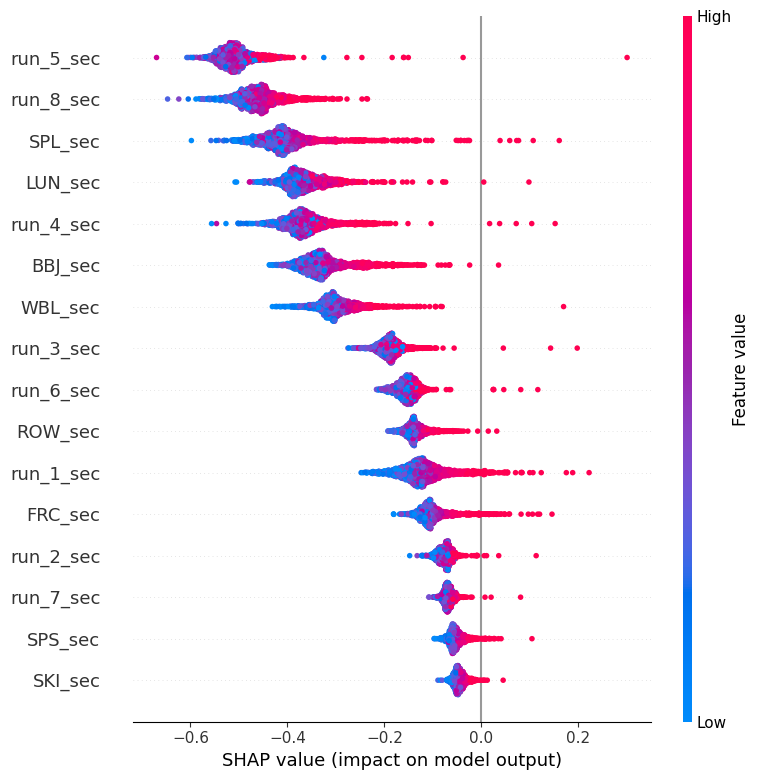

100%|===================| 7844/7846 [28:26<00:00]        

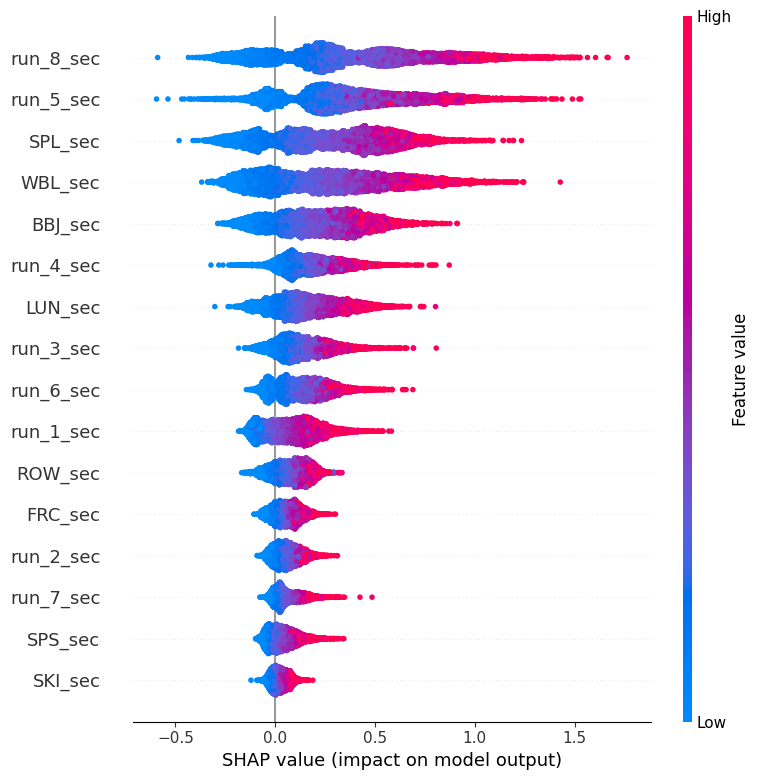

In [34]:
import shap

# Top 10 finishers of 2024 + 2025 races

X_top_10 = hyrox[(
    (hyrox["event_name"].str.contains("2024") | hyrox["event_name"].str.contains("2025"))
    & (hyrox["age_group_pct_group"] == 1.0)
    & (hyrox["age_group"].isin([AgeGroup.AG_25_29.value, AgeGroup.AG_30_34.value]))
)][X_COLS_RUN_SPLIT].astype(float)

shap_values_top_10 = shap.Explainer(rf_run_split, X_train_split.astype(float))(X_top_10)

shap.summary_plot(shap_values_top_10, X_top_10)


# Bottom 50 finishers of 2024 + 2025 races

X_bottom_50 = hyrox[(
    (hyrox["event_name"].str.contains("2024") | hyrox["event_name"].str.contains("2025"))
    & (hyrox["age_group_pct_group"] > 5.0)
    & (hyrox["age_group"].isin([AgeGroup.AG_25_29.value, AgeGroup.AG_30_34.value]))
)][X_COLS_RUN_SPLIT].astype(float)

shap_values_bottom_50 = shap.Explainer(rf_run_split, X_train_split.astype(float))(X_bottom_50)

shap.summary_plot(shap_values_bottom_50, X_bottom_50)

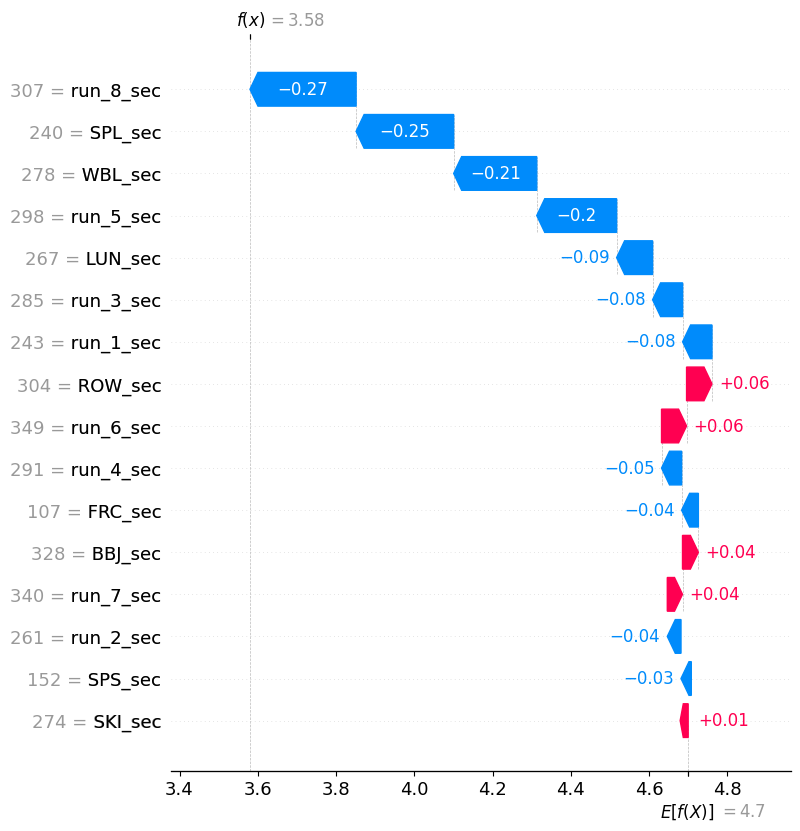

In [35]:
# Results for my own Houston 2025 race

X_leo = hyrox[(
    (hyrox["event_id"] == HOUSTON_EVENT_ID)
    & (hyrox["nationality"] == NATIONALITY_GER)
    & (hyrox["age_group"] == AgeGroup.AG_25_29.value)
)][X_COLS_RUN_SPLIT].astype(float)

shap_values_leo = shap.Explainer(rf_run_split, X_train_split.astype(float))(X_leo)

shap.plots.waterfall(shap_values_leo[0], max_display=16)